In [23]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from matplotlib import cm

import gradcamutils

In [3]:
!nvidia-smi

Wed Jul 29 05:24:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 18%   36C    P8    27W / 250W |    201MiB / 10986MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
def get_data(path, X_i, labels):
    slow = np.zeros((1, 64, 500))
    med = np.zeros((1, 64, 500))
    fast = np.zeros((1, 64, 500))
    s_i = 0
    m_i = 0
    f_i = 0
    for i, id in tqdm(enumerate(X_i)):
        s_path = os.path.join(path, "{}.npy".format(id))
        data = np.load(s_path)
        if i != 0:
            data = data[np.newaxis, ...]
        
        if labels[id - 1] == 0:
            if s_i == 0:
                slow[s_i] = data
            else:
                slow = np.append(slow, data, axis=0)
            
            s_i += 1
            continue
            
        if labels[id - 1] == 1:
            if m_i == 0:
                med[m_i] = data
            else:
                med = np.append(med, data, axis=0)
            
            m_i += 1
            continue
        
        if labels[id -1] == 2:
            if f_i == 0:
                fast[f_i] = data
            else:
                fast = np.append(fast, data, axis=0)
            
            f_i += 1
            continue
            
    print("slow: {}, med: {}, fast: {}".format(s_i, m_i, f_i))
    
    slow = np.swapaxes(slow, 1, 2)
    med = np.swapaxes(med, 1, 2)
    fast = np.swapaxes(fast, 1, 2)
    
    return slow, med, fast

def get_saliency_maps(model, X, top, H=128, W=128, batch_size=1000, layer='conv2d_13'):
    gradcam = np.empty((X.shape[0], H, W))
    N = len(X)
    cam = []
    for i in tqdm(range((N + batch_size - 1) // batch_size)):
        start = i * batch_size
        end = min((i+1) * batch_size, N)
        gradcam[start:end] = gradcamutils.grad_cam_batch(model, X[start:end], top[start:end], layer, H, W)
    
    return gradcam

def get_guided_backprop_vals(guided_model, X, layer='conv2d_13'):
    gbp = np.empty((X.shape))
    batch_size = 1000
    N = len(X)
    for i in tqdm(range((N + batch_size - 1) // batch_size)):
        start = i * batch_size
        end = min((i+1) * batch_size, N)
        gbp[start:end] = gradcamutils.guided_backprop(guided_model, X[start:end], layer)
        
    return gbp
def normalize(img):
    img = img.astype(np.float64)
    max_val = img.max()
    min_val = img.min()
    img = (img - min_val)/(max_val - min_val)
    return img

In [54]:
np.load("saliency_maps/med/TM-3.npy").shape

(6302, 500, 64)

In [3]:
def viz_temporal_saliency(sms, T, specs, fig, title, window=50, _return=False):
    avg_sm = normalize(np.mean(sms, axis=0))
    avg_sm_ch  = np.mean(sms, axis=2)
    
    if (len(T)//window) % 2 == 0: 
        ts = len(T)//window - 1
    else:
        ts = len(T)//window
    sm_ts = np.zeros((sms.shape[0], ts))
    
    for i,sm in enumerate(avg_sm_ch):
        sm_ch_ts = np.zeros((ts,))
        
        pre_st = np.mean(sm[0:100])
        sm_ch_ts[0] = pre_st
        for j,k in zip(range(1, ts), range(100, 500, window)):
            sm_ch_ts[j] = np.mean(sm[k:k+window])
        
        sm_ts[i] = sm_ch_ts
    
    ax_title = fig.add_subplot(specs[0])
    ax_title.axis('off')
    ax_title.set_title(title, fontdict={'size' : 35, 'weight' : 'bold'}, pad=0)
    
    ax0 = fig.add_subplot(specs[1])
    
#     ax0.set_title("GradCAM")
    
    im = ax0.imshow(normalize(avg_sm.transpose()), cmap='jet')
    ax0.get_yaxis().set_ticks([])
    ax0.set_ylabel("GradCAM")
    
    ax_colorbar = fig.add_subplot(specs[3])
    fig.colorbar(im, cax=ax_colorbar)
    
    t = np.array(list(range(0, 500, 50)))
    ax0.get_xaxis().set_ticks(t)
    
    labels = ["{} ms".format(T[i]) for i in t]
    ax0.get_xaxis().set_ticklabels(labels)
    
    
    ax1 = fig.add_subplot(specs[2])
#     colors = cm.plasma(np.linspace(0,1, ts))
    
    bx = ax1.boxplot(sm_ts, showfliers=False, 
                       showmeans=True, patch_artist=True)
    font = {'weight' : 'bold', 'size' : 22}
    ax1.set_xlabel("Time", fontdict=font)
    ax1.set_ylabel("Saliency Scores", fontdict=font)
    ax1.get_xaxis().set_ticks(range(1, ts+1))
    
    labels = ['Pre-stimulus']
    indices = np.array(list(range(100, 500, window)))
    lbl = ["{} - {} ms".format(T[i], T[i+window]) for i in indices if (i + window) < 500]
    labels.extend(lbl)
    labels.append("{} - {} ms".format(T[indices[-1]], 800))

    ax1.get_xaxis().set_ticklabels(labels)
    
    
    color = "#009688"
    for patch in bx['boxes']:
        patch.set_facecolor(color)
        patch.set_edgecolor('white')
    
    return sm_ts

## RT-10

In [50]:
X_test = pd.read_csv("data/X_test_10.csv", header=None).values.flatten()
X_train = pd.read_csv("data/X_train_10.csv", header=None).values.flatten()
Y = np.load("data/Y_RT_10.npy") 

In [51]:
s = Y[X_test -1]

s[s ==0].shape, s[s ==1].shape, s[s ==2].shape

((5972,), (6302,), (6227,))

In [21]:
X_test.shape

(18501,)

In [6]:
slow, med, fast = get_data("data/RT_20_data", X_test, Y)


slow: 5842, med: 6321, fast: 6213


In [7]:
X_test = np.vstack((slow, med, fast))

In [8]:
subject_test = pd.read_csv('data/sub_test_20.csv', index_col=0)

In [9]:
model = load_model("models/t-vgg_mod_rt_10.h5")
conv_model = model.layers[1]
conv_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 64)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 496, 16)           5136      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 492, 16)           1296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 246, 16)           0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 246, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 244, 32)           1568      
______________________________________________

In [10]:
top_slow = np.argmax(model.predict(slow), axis=1)
top_med = np.argmax(model.predict(med), axis=1)
top_fast = np.argmax(model.predict(fast), axis=1)
top_all = np.argmax(model.predict(X_test), axis=1)

In [11]:
smap_slow = get_saliency_maps(conv_model, slow, top_slow, H=500, W=64, layer='conv1d_7', batch_size=1000)
smap_med = get_saliency_maps(conv_model, med, top_med, H=500, W=64, layer='conv1d_7', batch_size=1000)
smap_fast = get_saliency_maps(conv_model, fast, top_fast, H=500, W=64, layer='conv1d_7', batch_size=1000)
smap_all = get_saliency_maps(conv_model, X_test, top_all, H=500, W=64, layer='conv1d_7', batch_size=1000)

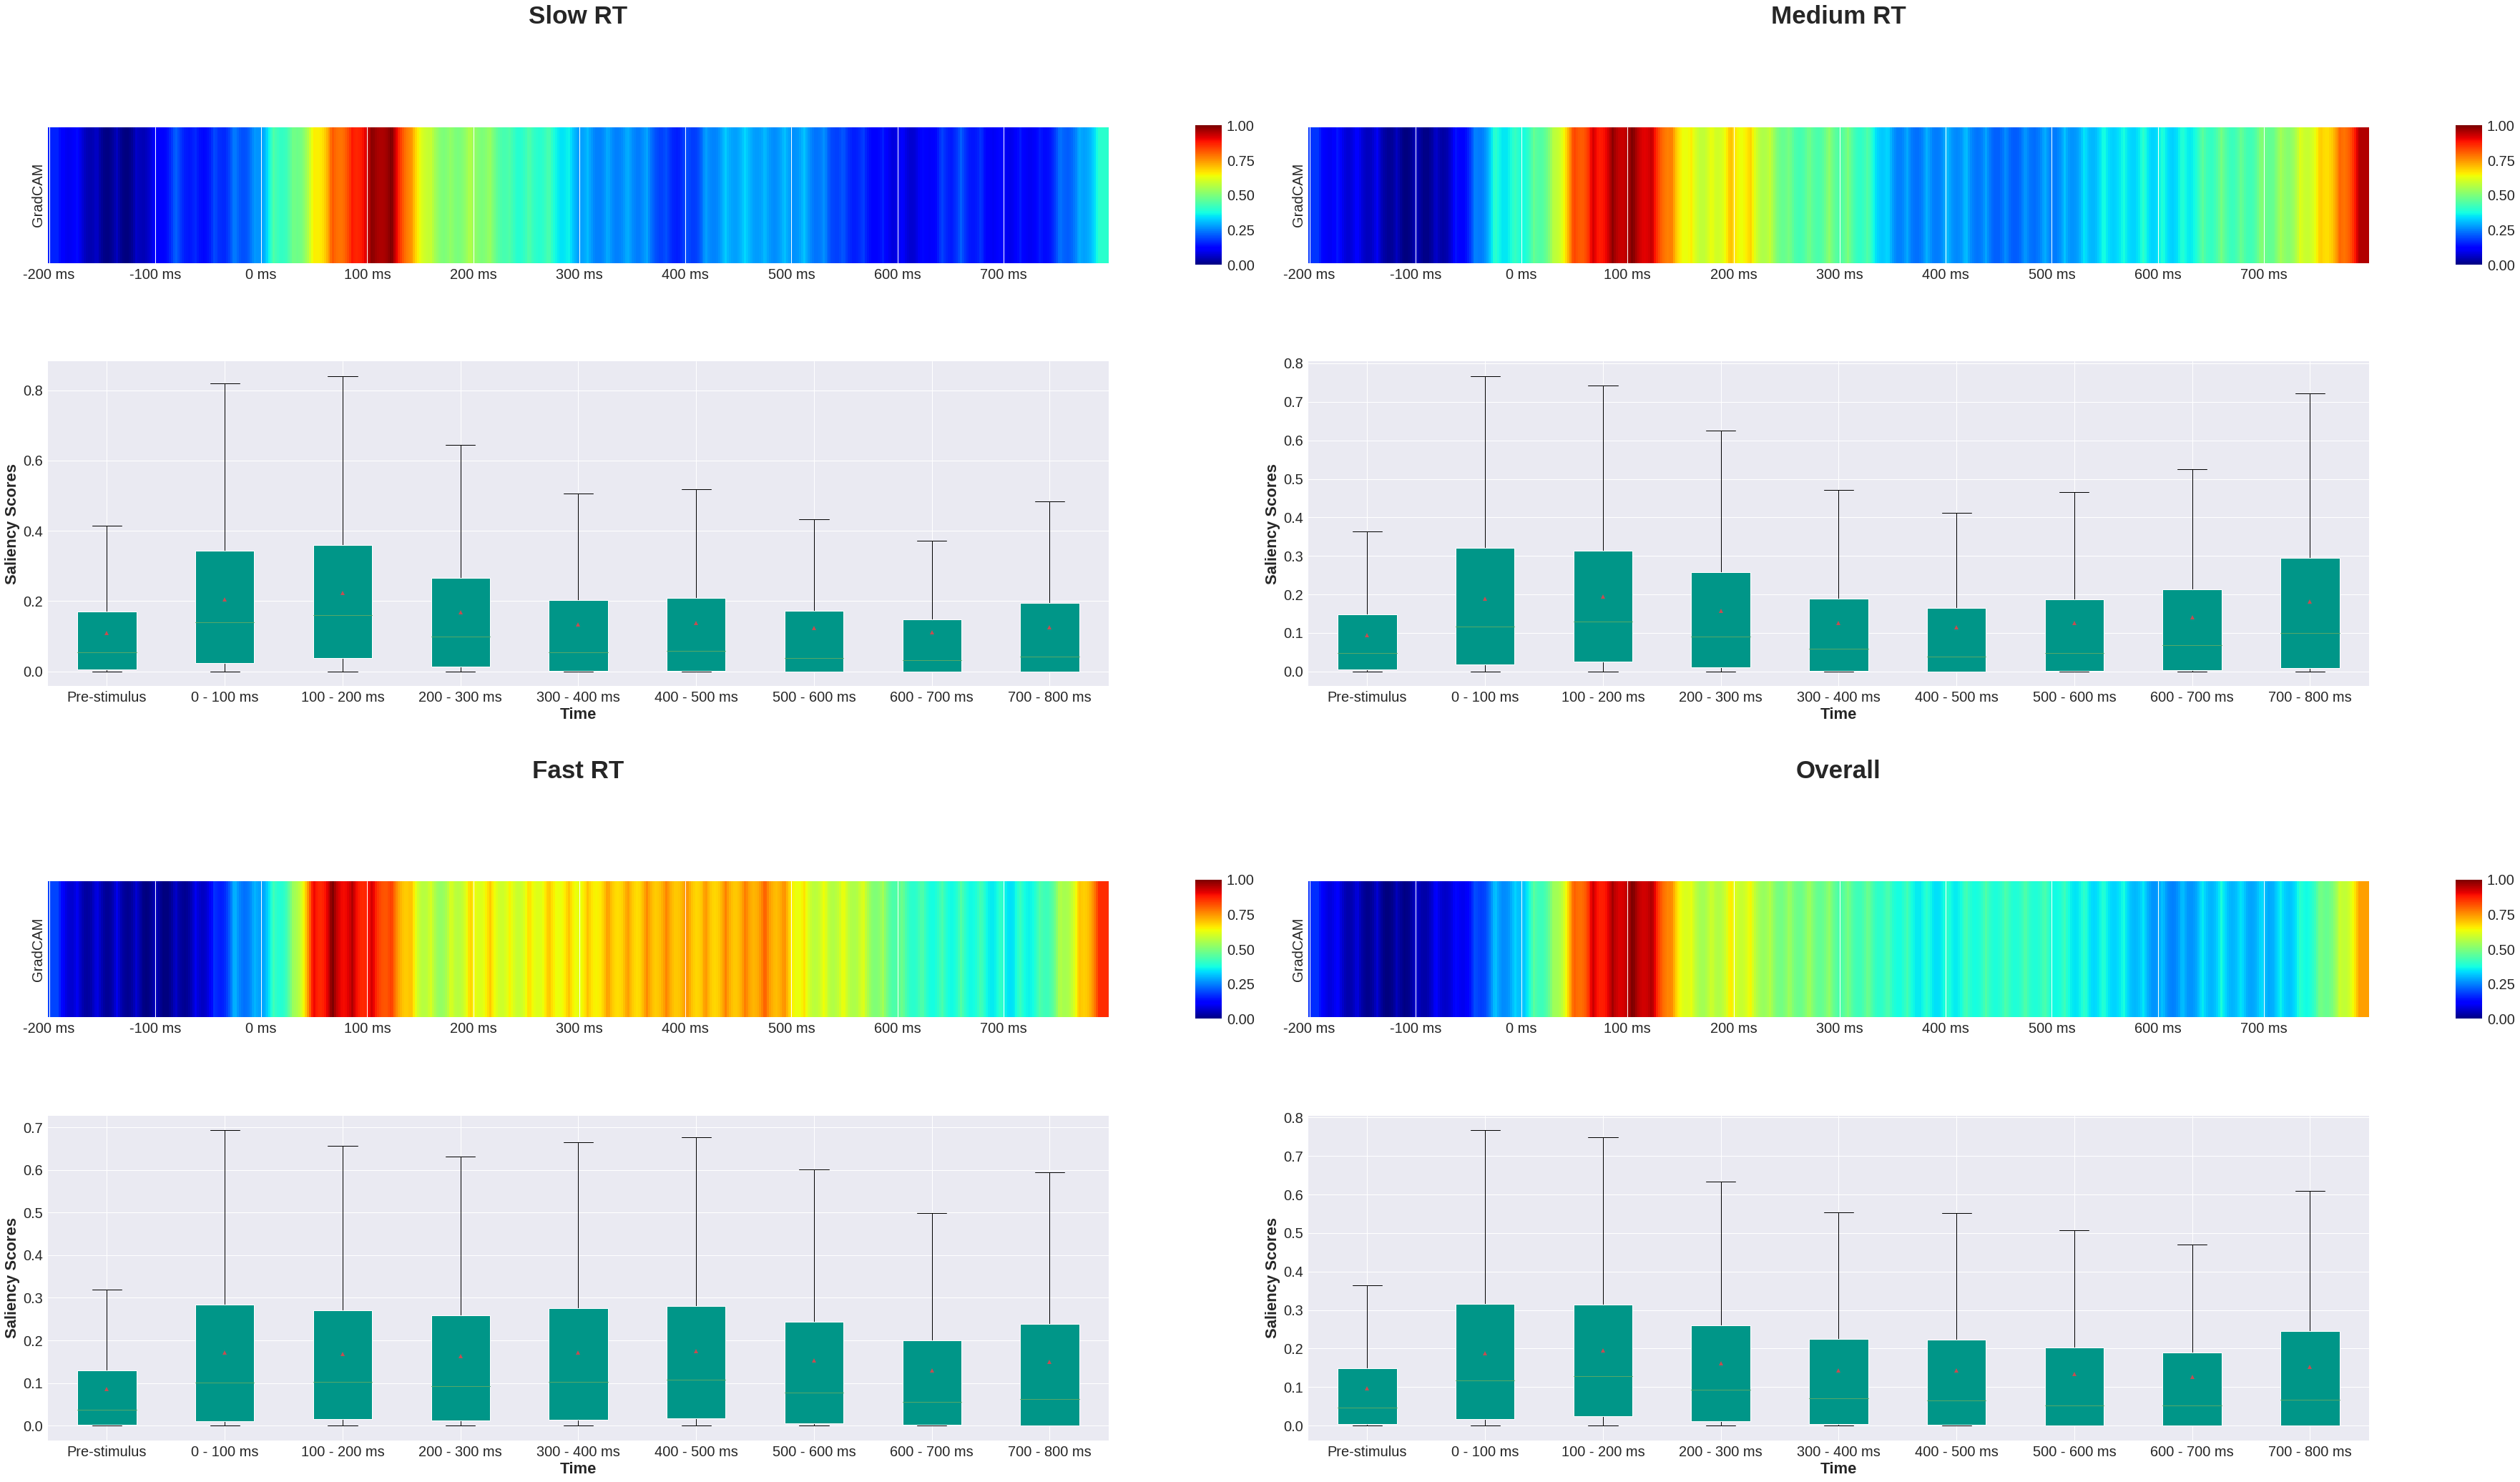

In [12]:
# smap_slow = smap[0:len(slow)]
# smap_med = smap[len(slow):len(slow) + len(med)]
# smap_fast = smap[len(slow) + len(med):len(fast) + len(slow) + len(med)]
# avg_smap = np.mean(smap, axis=0)

T = np.linspace(-200, 798, 500, dtype=np.int)

# smap_heatmaps = [avg_smap_slow, avg_smap_med, avg_smap_fast, avg_smap]
# titles = ['slow', 'med', 'fast', 'overall']

plt.style.use('seaborn')
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

fig = plt.figure(constrained_layout=False, figsize=(50, 30))

widths = [4, 0.1, 4, 0.1]
heights = [0.00001, 3, 7, 0.00001, 3, 7]

spec = fig.add_gridspec(nrows=6, ncols=4, width_ratios=widths,
                          height_ratios=heights)

# ax_slow_title = fig.add_subplot(spec[0,0])
# ax_slow_title.set_title

specs_slow = [spec[0,0], spec[1,0], spec[2,0], spec[1,1]]
specs_med = [spec[0,2], spec[1,2], spec[2,2], spec[1,3]]
specs_fast = [spec[3,0], spec[4,0], spec[5,0], spec[4, 1]]
specs_all = [spec[3,2], spec[4,2], spec[5,2], spec[4,3]]

smap_ts_slow = viz_temporal_saliency(smap_slow, T, specs_slow, fig, 'Slow RT', 50)
smap_ts_med = viz_temporal_saliency(smap_med, T, specs_med, fig, 'Medium RT', 50)
smap_ts_fast = viz_temporal_saliency(smap_fast, T, specs_fast, fig, 'Fast RT', 50)
smap_ts = viz_temporal_saliency(smap_all, T, specs_all, fig, 'Overall', 50)

fig.tight_layout(pad=3.2)

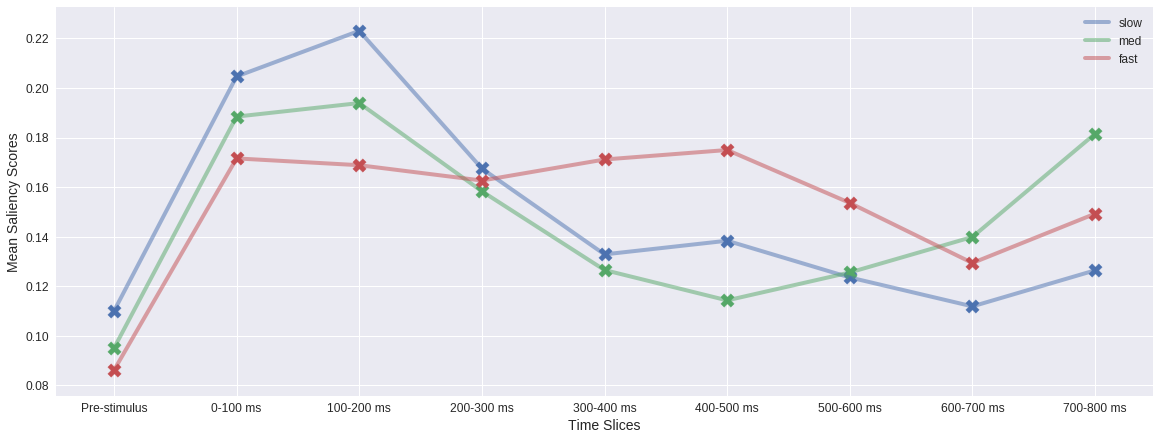

In [13]:
avg_slow = np.mean(smap_ts_slow, axis=0)
avg_med = np.mean(smap_ts_med, axis=0)
avg_fast = np.mean(smap_ts_fast, axis=0)
time_ticks = np.arange(0,9,1)
time_labels = ['Pre-stimulus']
time_labels.extend(['{}-{} ms'.format(T[i], T[i+50]) for i in range(100, 500, 50) if i + 50 < 500])
time_labels.append('700-800 ms')

smapALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

fig = plt.figure(constrained_layout=True, figsize=(16,6))

plt.plot(avg_slow, label='slow', alpha=0.5, linewidth=4)
plt.scatter(time_ticks, avg_slow, marker='X', s=180, alpha=1)

plt.plot(avg_med, label='med', alpha=0.5, linewidth=4)
plt.scatter(time_ticks, avg_med, marker='X', s=180, alpha=1)

plt.plot(avg_fast, label='fast', alpha=0.5, linewidth=4)
plt.scatter(time_ticks, avg_fast, marker='X', s=180, alpha=1)

plt.xticks(time_ticks, labels=time_labels)
# plt.ylim([0.2,0.35])
plt.ylabel("Mean Saliency Scores", fontdict={'size' : 14})
plt.xlabel("Time Slices", fontdict={'size' : 14})
plt.legend()

# fig.tight_layout(pad=6.2)

## RT-50

In [4]:
X_test = np.load("data/X_test_sc.npy")
X_val = np.load("data/X_val_sc.npy")

Y_test = np.load("data/Y_test_sc.npy")
Y_val = np.load("data/Y_val_sc.npy")

subject_val = np.load('data/sub_val_sc.npy')
subject_test = np.load('data/sub_test_sc.npy')

In [5]:
X_test = np.swapaxes(X_test, 1,2)
X_test.shape

(7524, 500, 64)

In [6]:
# X_test = np.vstack((X_test, X_val))
# Y_test = np.vstack((Y_test, Y_val))

# subject_test = np.concatenate((subject_test, subject_val))

# X_test = np.swapaxes(X_val, 1,2)

Y_test = np.argmax(Y_test, axis=1)

In [7]:
slow_i = np.where(Y_test == 0)
med_i = np.where(Y_test == 1)
fast_i = np.where(Y_test == 2)

slow = X_test[slow_i]
med = X_test[med_i]
fast = X_test[fast_i]

slow.shape, med.shape, fast.shape

((1534, 500, 64), (2956, 500, 64), (3034, 500, 64))

In [8]:
model = load_model("models/t-vgg_mod_10.h5")
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 498, 16)           3088      
_________________________________________________________________
batch_normalization (BatchNo (None, 498, 16)           64        
_________________________________________________________________
activation (Activation)      (None, 498, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 16)           784       
_________________________________________________________________
batch_normalization_1 (Batch (None, 496, 16)           64        
_________________________________________________________________
activation_1 (Activation)    (None, 496, 16)           0         
_________________________________________

In [9]:
top_slow = np.argmax(model.predict(slow), axis=1)
top_med = np.argmax(model.predict(med), axis=1)
top_fast = np.argmax(model.predict(fast), axis=1)
top_all = np.argmax(model.predict(X_test), axis=1)

In [10]:
smap_slow = get_saliency_maps(model, slow, top_slow, H=500, W=64, layer='conv1d_5', batch_size=1000)
smap_med = get_saliency_maps(model, med, top_med, H=500, W=64, layer='conv1d_5', batch_size=1000)
smap_fast = get_saliency_maps(model, fast, top_fast, H=500, W=64, layer='conv1d_5', batch_size=1000)
smap_all = get_saliency_maps(model, X_test, top_all, H=500, W=64, layer='conv1d_5', batch_size=1000)

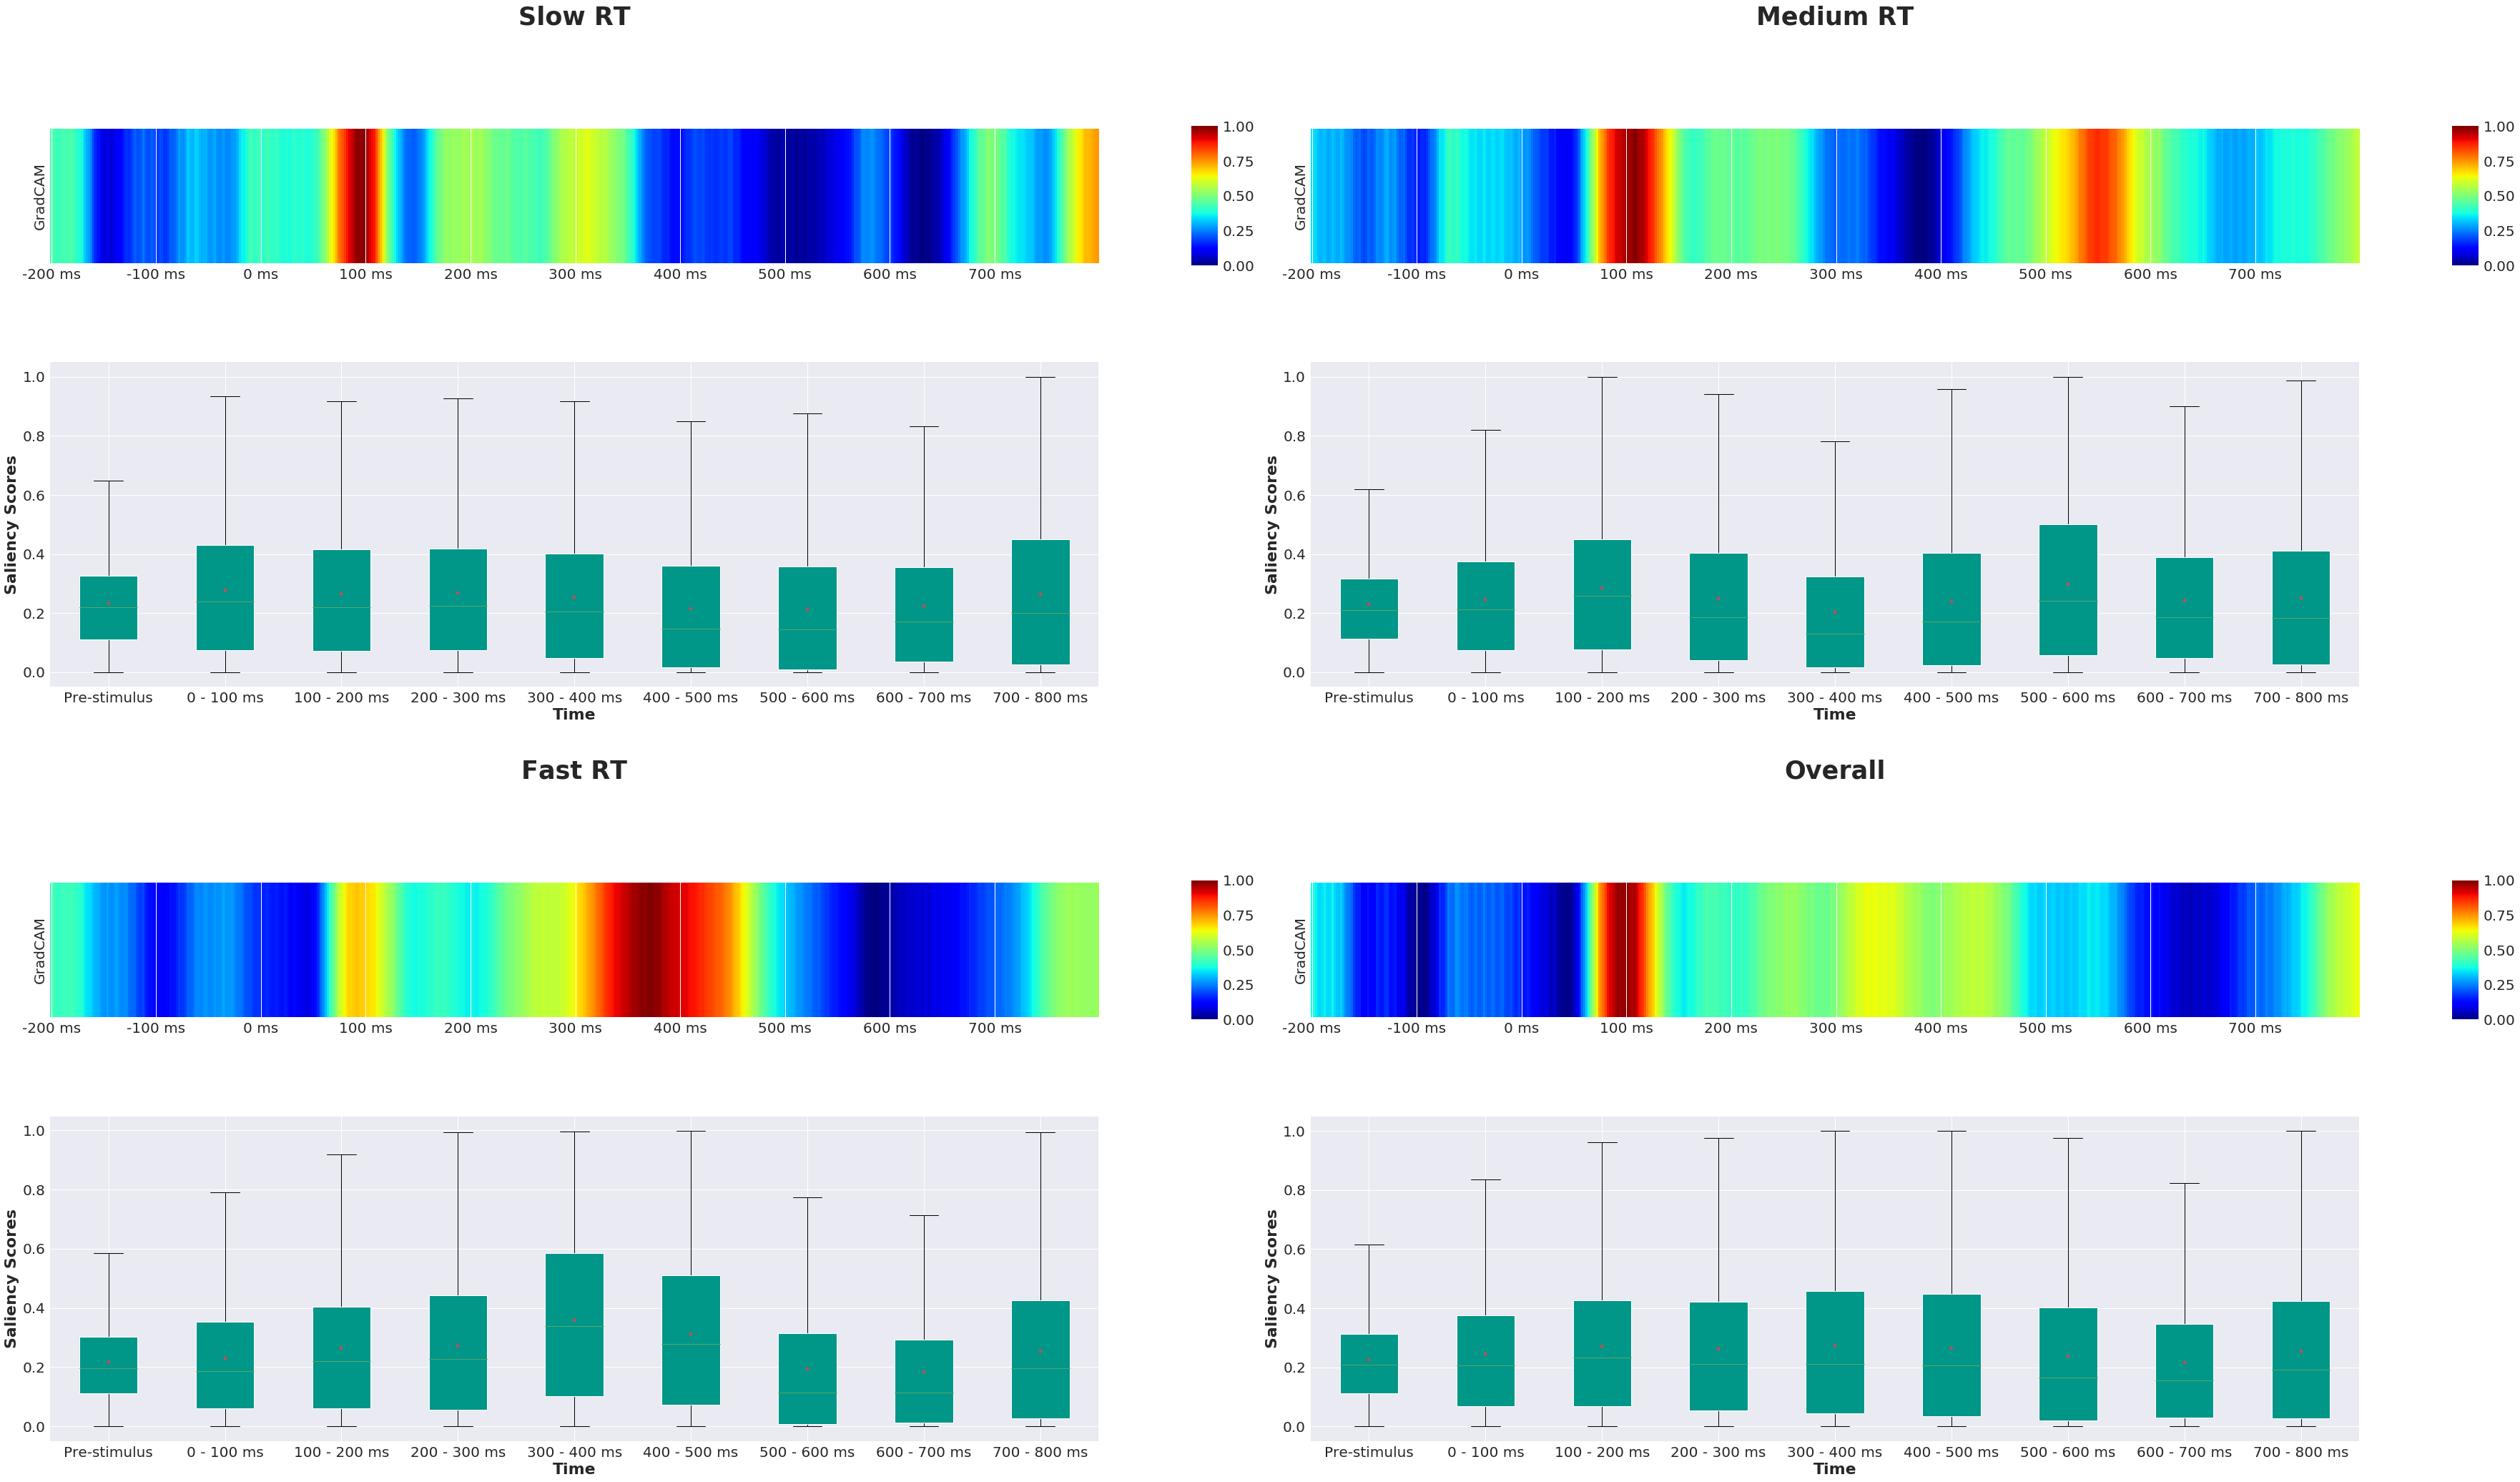

In [12]:
# smap_slow = smap[0:len(slow)]
# smap_med = smap[len(slow):len(slow) + len(med)]
# smap_fast = smap[len(slow) + len(med):len(fast) + len(slow) + len(med)]
# avg_smap = np.mean(smap, axis=0)

T = np.linspace(-200, 798, 500, dtype=np.int)

# smap_heatmaps = [avg_smap_slow, avg_smap_med, avg_smap_fast, avg_smap]
# titles = ['slow', 'med', 'fast', 'overall']

plt.style.use('seaborn')
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

fig = plt.figure(constrained_layout=False, figsize=(50, 30))

widths = [4, 0.1, 4, 0.1]
heights = [0.00001, 3, 7, 0.00001, 3, 7]

spec = fig.add_gridspec(nrows=6, ncols=4, width_ratios=widths,
                          height_ratios=heights)

# ax_slow_title = fig.add_subplot(spec[0,0])
# ax_slow_title.set_title

specs_slow = [spec[0,0], spec[1,0], spec[2,0], spec[1,1]]
specs_med = [spec[0,2], spec[1,2], spec[2,2], spec[1,3]]
specs_fast = [spec[3,0], spec[4,0], spec[5,0], spec[4, 1]]
specs_all = [spec[3,2], spec[4,2], spec[5,2], spec[4,3]]

smap_ts_slow = viz_temporal_saliency(smap_slow, T, specs_slow, fig, 'Slow RT', 50)
smap_ts_med = viz_temporal_saliency(smap_med, T, specs_med, fig, 'Medium RT', 50)
smap_ts_fast = viz_temporal_saliency(smap_fast, T, specs_fast, fig, 'Fast RT', 50)
smap_ts = viz_temporal_saliency(smap_all, T, specs_all, fig, 'Overall', 50)

fig.tight_layout(pad=3.2)

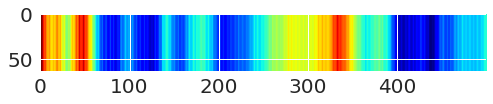

In [17]:
plt.imshow(np.mean(smap_fast, axis=0).transpose(), cmap='jet')

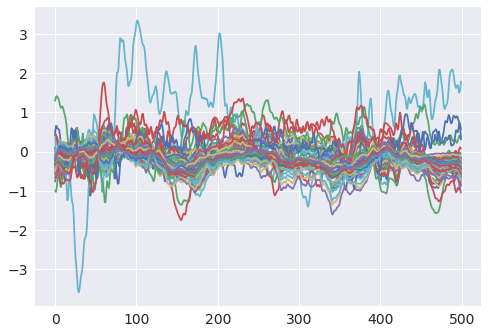

In [26]:
X = X_test[1]
X = X - np.mean(X[0:100], axis=0)
plt.plot(X)
plt.show()

In [28]:
X_test.min()

-51.10373116922013

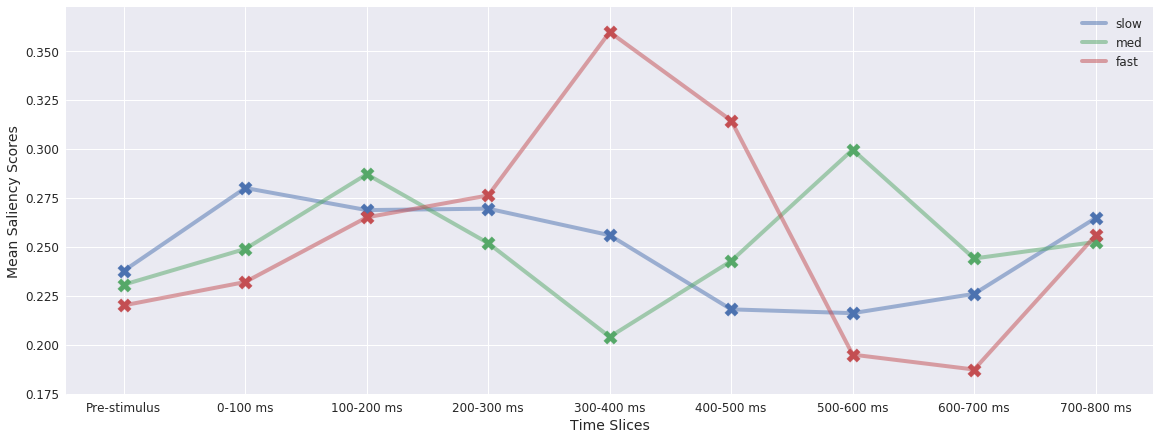

In [13]:
avg_slow = np.mean(smap_ts_slow, axis=0)
avg_med = np.mean(smap_ts_med, axis=0)
avg_fast = np.mean(smap_ts_fast, axis=0)
time_ticks = np.arange(0,9,1)
time_labels = ['Pre-stimulus']
time_labels.extend(['{}-{} ms'.format(T[i], T[i+50]) for i in range(100, 500, 50) if i + 50 < 500])
time_labels.append('700-800 ms')

smapALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

fig = plt.figure(constrained_layout=True, figsize=(16,6))

plt.plot(avg_slow, label='slow', alpha=0.5, linewidth=4)
plt.scatter(time_ticks, avg_slow, marker='X', s=180, alpha=1)

plt.plot(avg_med, label='med', alpha=0.5, linewidth=4)
plt.scatter(time_ticks, avg_med, marker='X', s=180, alpha=1)

plt.plot(avg_fast, label='fast', alpha=0.5, linewidth=4)
plt.scatter(time_ticks, avg_fast, marker='X', s=180, alpha=1)

plt.xticks(time_ticks, labels=time_labels)
# plt.ylim([0.2,0.35])
plt.ylabel("Mean Saliency Scores", fontdict={'size' : 14})
plt.xlabel("Time Slices", fontdict={'size' : 14})
plt.legend()

# fig.tight_layout(pad=6.2)

## ANOVA

In [14]:
data = np.vstack((smap_ts_slow, smap_ts_med, smap_ts_fast))
g_slow = np.array(['slow'] * len(slow)).reshape((-1,1))
g_med = np.array(['med'] * len(med)).reshape((-1,1))
g_fast = np.array(['fast'] * len(fast)).reshape((-1,1))
groups = np.vstack((g_slow, g_med, g_fast))
columns = ['Pre_stimulus', 'ms_1', 'ms_2', 'ms_3', 'ms_4', 'ms_5', 'ms_6', 
           'ms_7', 'ms_8']

df = pd.DataFrame(data, columns=columns)
df.insert(0, 'groups', groups)
df.insert(1, 'subjects', subject_test)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7524 entries, 0 to 7523
Data columns (total 11 columns):
groups          7524 non-null object
subjects        7524 non-null object
Pre_stimulus    7524 non-null float64
ms_1            7524 non-null float64
ms_2            7524 non-null float64
ms_3            7524 non-null float64
ms_4            7524 non-null float64
ms_5            7524 non-null float64
ms_6            7524 non-null float64
ms_7            7524 non-null float64
ms_8            7524 non-null float64
dtypes: float64(9), object(2)
memory usage: 646.7+ KB


In [15]:
p_values = []
f_values = []
for var in columns:
    model = ols('{} ~ C(groups)'.format(var), data=df).fit()
    anova_table = sm.stats.anova_lm(model)
    p_val = anova_table['PR(>F)'].values[0]
    f_val = anova_table['F'].values[0]
    p_values.append(p_val)
    f_values.append(f_val)

Text(0, 0.5, 'p-values (-log scale)')

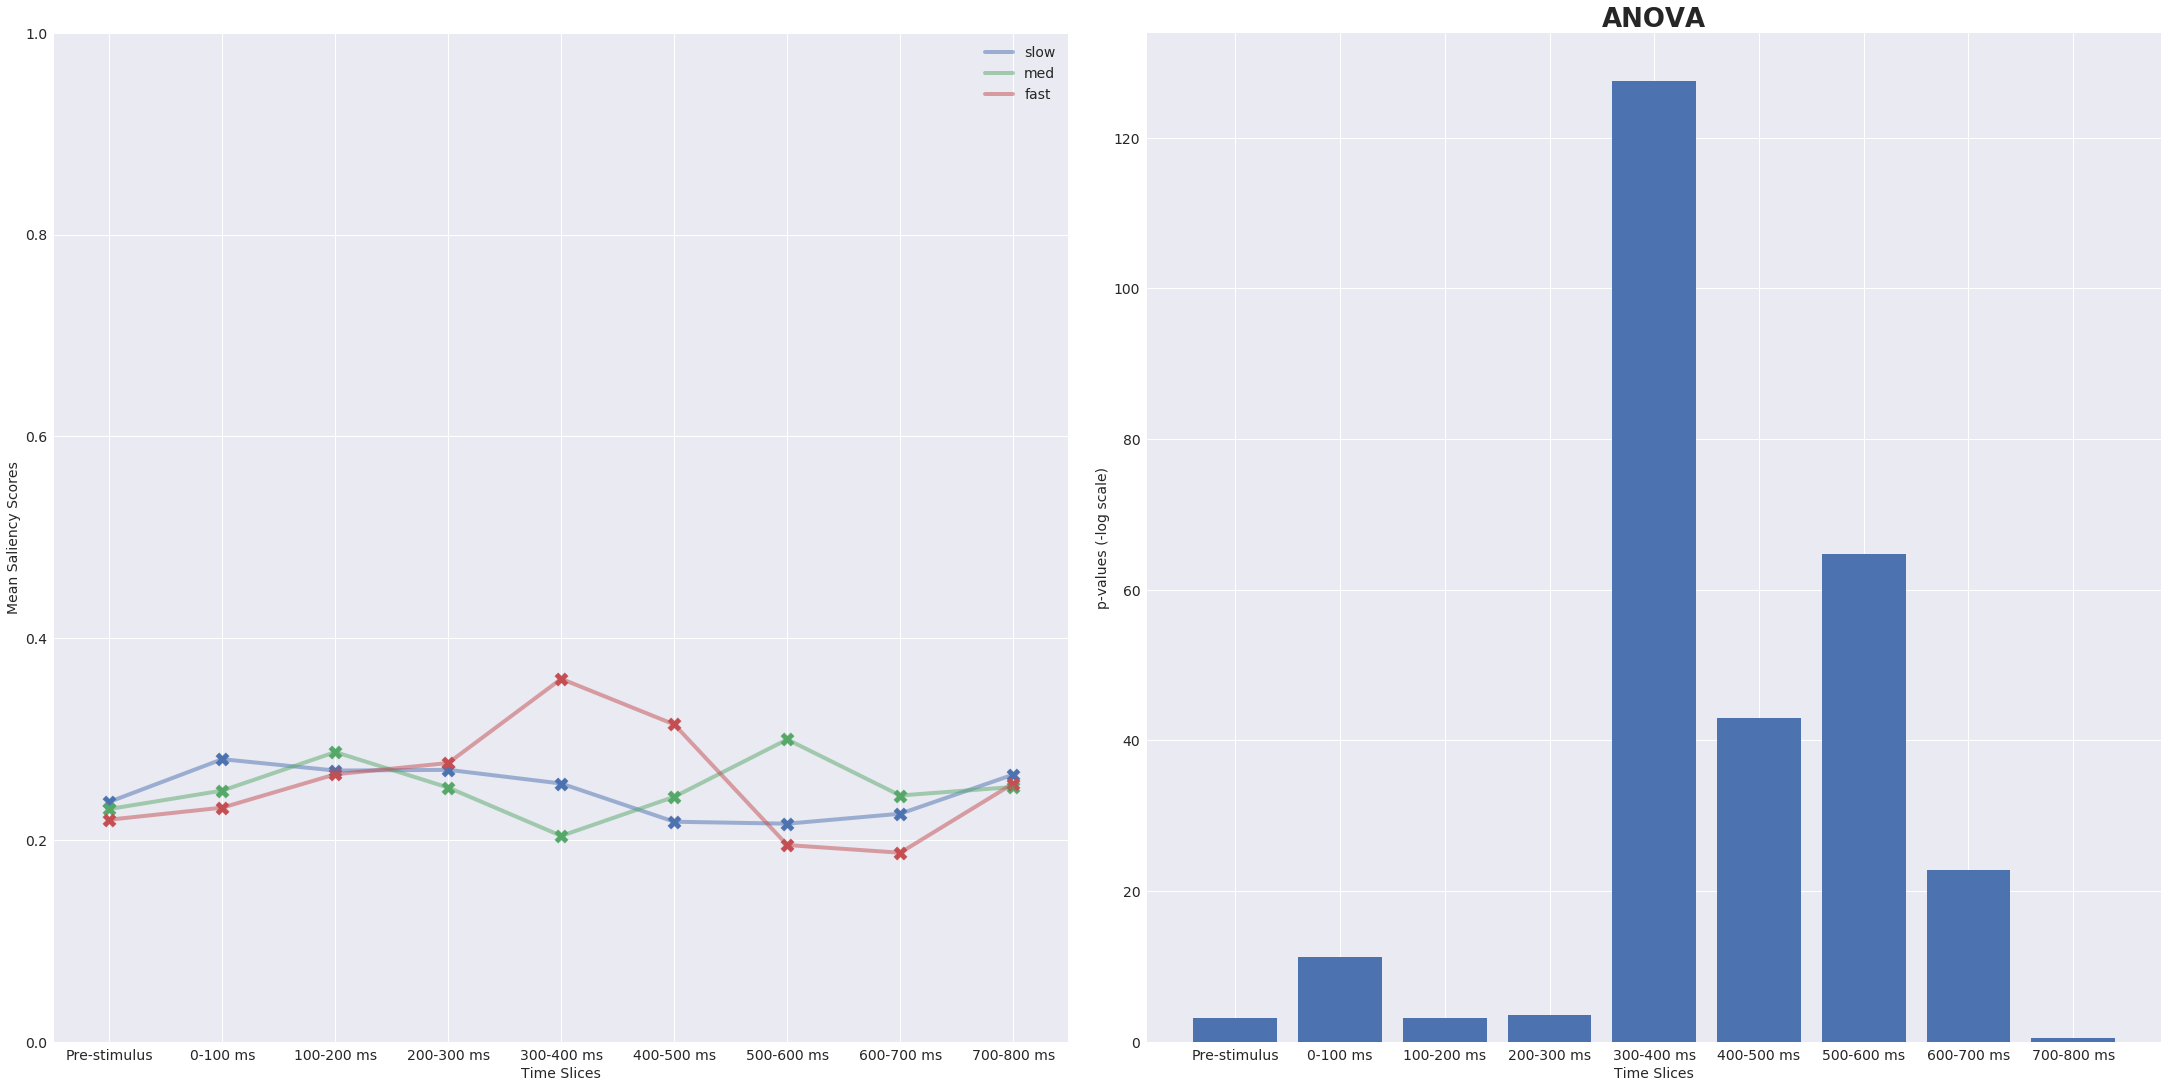

In [16]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)


fig, ax = plt.subplots(ncols=2, figsize=(30, 15), constrained_layout=True)

ax[0].plot(avg_slow, label='slow', alpha=0.5, linewidth=4)
ax[0].scatter(time_ticks, avg_slow, marker='X', s=180, alpha=1)

ax[0].plot(avg_med, label='med', alpha=0.5, linewidth=4)
ax[0].scatter(time_ticks, avg_med, marker='X', s=180, alpha=1)

ax[0].plot(avg_fast, label='fast', alpha=0.5, linewidth=4)
ax[0].scatter(time_ticks, avg_fast, marker='X', s=180, alpha=1)

ax[0].set_xticks(time_ticks)
ax[0].set_xticklabels(time_labels)
ax[0].set_ylim([0,1])
ax[0].set_ylabel("Mean Saliency Scores", fontdict={'size' : 14})
ax[0].set_xlabel("Time Slices", fontdict={'size' : 14})
ax[0].legend()


ax[1].set_title("ANOVA", fontdict={'size' : 26, 'weight': 'bold'})
ax[1].bar(time_labels, -np.log10(p_values))
ax[1].set_xlabel("Time Slices", fontdict={'size' : 14})
ax[1].set_ylabel("p-values (-log scale)", fontdict={'size' : 14})

In [17]:
df_1 = df
df_1.columns = ['groups', 'subjects', 'Pre-stimulus','0-100 ms','100-200 ms','200-300 ms','300-400 ms','400-500 ms','500-600 ms','600-700 ms','700-800 ms'] 
df_melt = pd.melt(df_1.reset_index(), id_vars=['groups', 'subjects'], value_vars=['Pre-stimulus','0-100 ms','100-200 ms','200-300 ms','300-400 ms','400-500 ms','500-600 ms','600-700 ms','700-800 ms'])

df_melt.columns = ['group', 'sub', 'timeslice', 'salience']
df_melt.groupby(['group', 'sub', 'timeslice']).mean()

salience
group sub timeslice             
fast  S4  0-100 ms      0.232697
          100-200 ms    0.295628
          200-300 ms    0.471345
          300-400 ms    0.425373
          400-500 ms    0.230012
...                          ...
slow  N6  400-500 ms    0.280727
          500-600 ms    0.312034
          600-700 ms    0.319591
          700-800 ms    0.273566
          Pre-stimulus  0.154209

[468 rows x 1 columns]

In [34]:
# np.where(df_melt['subjects'].values == 'S4')[0].shape

(3780,)

In [18]:
df_melt.to_csv("saliency_scores_RT_50_t_vgg_10.csv")

In [46]:
# mp = MultiComparison(df_melt['value'], df_melt[['time-slices', 'groups']])

IndexError: too many indices for array

In [44]:
# print(mp.allpairtest(stats.ttest_rel, method='bonf', pvalidx=1)[0])

Test Multiple Comparison ttest_rel 
FWER=0.05 method=bonf
alphacSidak=0.00, alphacBonf=0.001
  group1      group2      stat    pval  pval_corr reject
--------------------------------------------------------
  0-100 ms   100-200 ms   1.7759 0.0758       1.0  False
  0-100 ms   200-300 ms -20.7059    0.0       0.0   True
  0-100 ms   300-400 ms -41.1379    0.0       0.0   True
  0-100 ms   400-500 ms -32.8035    0.0       0.0   True
  0-100 ms   500-600 ms  -18.833    0.0       0.0   True
  0-100 ms   600-700 ms  -2.1617 0.0307       1.0  False
  0-100 ms   700-800 ms  -8.8072    0.0       0.0   True
  0-100 ms Pre-stimulus   4.6317    0.0    0.0001   True
100-200 ms   200-300 ms -26.4844    0.0       0.0   True
100-200 ms   300-400 ms -41.2683    0.0       0.0   True
100-200 ms   400-500 ms -31.4244    0.0       0.0   True
100-200 ms   500-600 ms -18.4285    0.0       0.0   True
100-200 ms   600-700 ms    -3.54 0.0004    0.0144   True
100-200 ms   700-800 ms  -9.6342    0.0       0.0   

In [75]:
stats.ttest_rel(axis=1)

TypeError: ttest_rel() missing 2 required positional arguments: 'a' and 'b'